# Data Inspection
Using forward scattering information.

In [18]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *
from scipy import signal
%matplotlib notebook

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Loads data into segments of npoints
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data)/np.array(sum_data), 
                    np.array(y_data)/np.array(sum_data), np.array(sum_data), 
                    np.array(particle_group),target_fix

        
def PSD(xdata, ydata, dt):
    
    freqs, PSD_x = signal.welch(xdata,1/dt)
    freqs, PSD_y = signal.welch(ydata,1/dt)
    
    return PSD_x, PSD_y, freqs


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            
            fft_x, fft_y,lll = PSD(x_data[i][j],y_data[i][j],10e-5)
            fft_x = fft_x[init:end]
            fft_y = fft_y[init:end]
            
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs


# Load the data

In [3]:
folder = "D:data OT - TT//VicenteSame//"
npoints   =  20000
target, x_data, y_data, sum_data, particle_group,target_fix = load_data(npoints, folder)

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

In [16]:
unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um',' $\mu$m ').replace('POLY','PS'))

In [31]:
new_data_x = []
for i in range(0,len(x_data)):
    for j in range(0,len(x_data[i])):
        new_data_x.append(x_data[i][j])
new_data_x = np.array(new_data_x)

new_data_y = []
for i in range(0,len(y_data)):
    for j in range(0,len(y_data[i])):
        new_data_y.append(y_data[i][j])
new_data_y = np.array(new_data_y)

new_data_sum = []
for i in range(0,len(sum_data)):
    for j in range(0,len(sum_data[i])):
        new_data_sum.append(sum_data[i][j])
new_data_sum = np.array(new_data_sum)

# Plot Signals

<IPython.core.display.Javascript object>


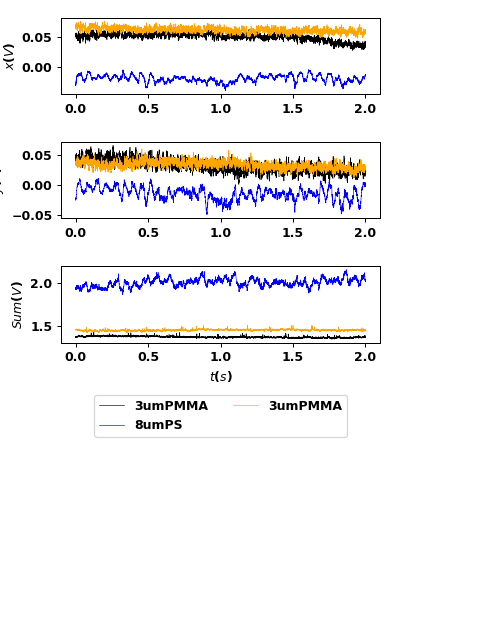

In [57]:
iis = [0,600,30]
dt = 10e-5
time = np.arange(0,len(new_data_x[0]))*dt

fig, ax = subplots(3,1,figsize=[6,4])
#suptitle(target[ii])

for i in range(0,len(iis)):
    ii = iis[i]
    
    ax[0].plot(time, new_data_x[ii],ls = '-',color=colors[i],lw = 0.5)
    ax[0].set_ylabel('$x(V)$')
    

    ax[1].plot(time, new_data_y[ii],ls = '-',color=colors[i],lw = 0.5)
    ax[1].set_ylabel('$y(V)$')

    ax[2].plot(time, new_data_sum[ii],ls = '-',color=colors[i],lw = 0.5,label = target[ii])
    ax[2].set_ylabel('$Sum(V)$')

    ax[2].set_xlabel('$t(s)$')
    ax[2].legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.6),ncol=2)
    
tight_layout()

<IPython.core.display.Javascript object>


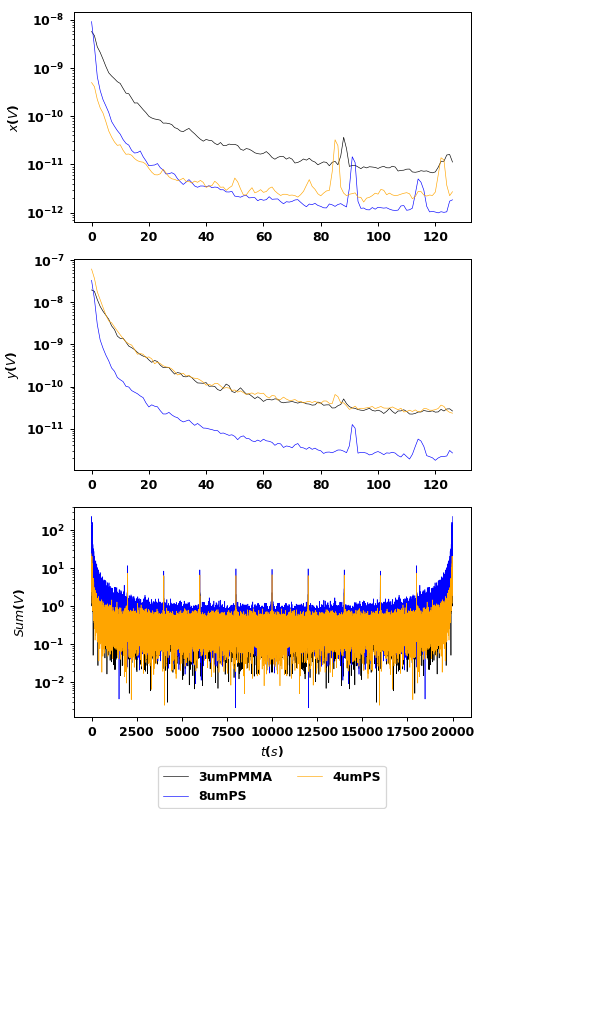

In [66]:
iis = [0,600,300]
fig, ax = subplots(3,1,figsize=[6,10])
#suptitle(target[ii])

for i in range(0,len(iis)):
    ii = iis[i]
    
    ax[0].plot(data_X[ii],ls = '-',color=colors[i],lw = 0.5)
    ax[0].set_ylabel('$x(V)$')
    ax[0].set_yscale('log')
    

    ax[1].plot(data_Y[ii],ls = '-',color=colors[i],lw = 0.5)
    ax[1].set_ylabel('$y(V)$')
    ax[1].set_yscale('log')

    ax[2].plot(data_Sum[ii],ls = '-',color=colors[i],lw = 0.5,label = target[ii])
    ax[2].set_ylabel('$Sum(V)$')
    ax[2].set_yscale('log')
    
    ax[2].set_xlabel('$t(s)$')
    ax[2].legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.2),ncol=2)
    
tight_layout()

# PCA analysis

<IPython.core.display.Javascript object>


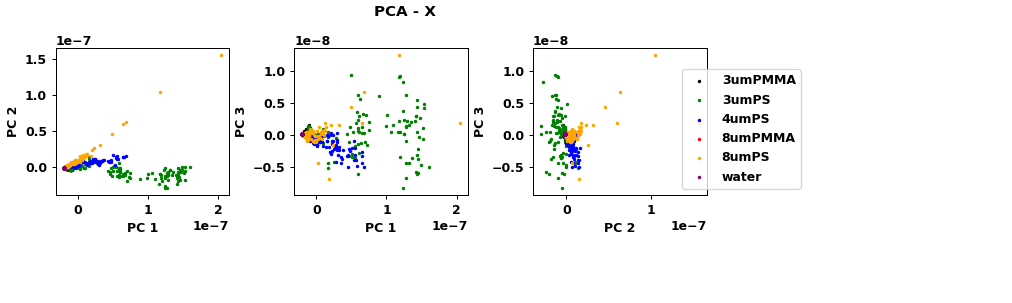

<IPython.core.display.Javascript object>


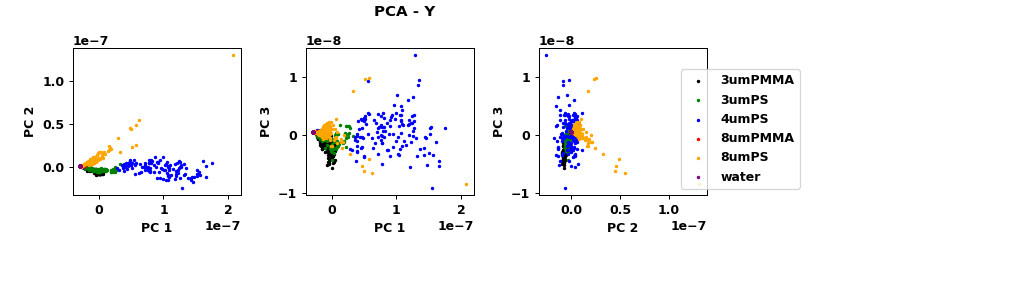

<IPython.core.display.Javascript object>


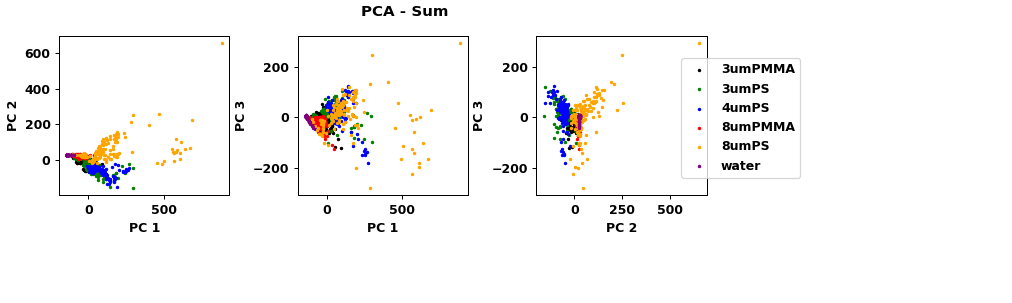

In [145]:
import sklearn
import umap

colors={'3umPMMA':'k', 
        '3umPS':'g', 
        '4umPS':'b', 
        '8umPMMA':'r', 
        '8umPS':'orange', 
        'water':'purple'}

ncomp = 10
pca_model =  sklearn.decomposition.PCA(n_components=ncomp)
#pca_model =  umap.UMAP( metric='euclidean', min_dist=0.2, n_components=ncomp,n_neighbors=10)

data_dimensions = [data_X,data_Y,data_Sum]
titles = ['PCA - X','PCA - Y','PCA - Sum']
for jj in range(0,len(data_dimensions)):
    current_data = data_dimensions[jj]
    pca_model.fit(current_data)
    pcs_x = pca_model.transform(current_data)

    fig, ax = subplots(1,3,figsize=[10,3])
    suptitle(titles[jj])
    for particle_type in np.unique(target):
        index = np.where(np.array(target)==particle_type)
        ax[0].scatter(pcs_x[index,0],pcs_x[index,1],c=colors[particle_type],s=3)
        ax[1].scatter(pcs_x[index,0],pcs_x[index,2],c=colors[particle_type],s=3)
        ax[2].scatter(pcs_x[index,1],pcs_x[index,2],c=colors[particle_type],s=3,label=particle_type)

    ax[0].set_xlabel('PC 1')
    ax[0].set_ylabel('PC 2')

    ax[1].set_xlabel('PC 1')
    ax[1].set_ylabel('PC 3')

    ax[2].set_xlabel('PC 2')
    ax[2].set_ylabel('PC 3')
    ax[2].legend(loc = 'upper center', bbox_to_anchor=(1.2,0.9),ncol=1)

    tight_layout()

<IPython.core.display.Javascript object>


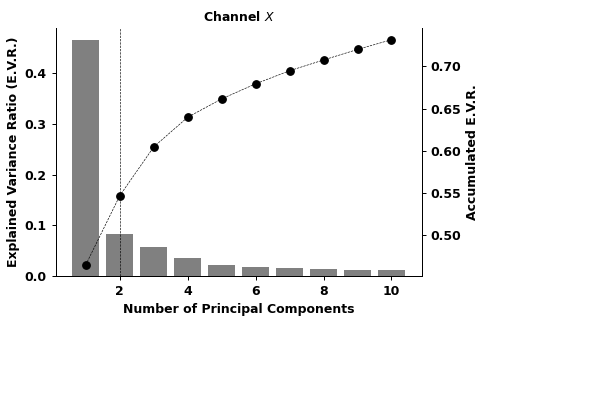

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.cumsum is deprecated and will be removed in SciPy 2.0.0, use numpy.cumsum instead
  del sys.path[0]


In [146]:
fs=10
subplots(figsize=[6,4])
ax=gca()
ax.bar(range(1,ncomp+1),pca_model.explained_variance_ratio_,color='grey')
ax.axvline(x=2,ls='--',lw=0.5,color='k')
ax.set_xlabel('Number of Principal Components',fontsize=fs)
ax.set_ylabel('Explained Variance Ratio (E.V.R.)',fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()

ax2.plot(range(1,ncomp+1),cumsum(pca_model.explained_variance_ratio_),color='k',marker='o',ls='--',lw=0.5)
ax2.set_ylabel('Accumulated E.V.R.',fontsize=fs)
ax2.spines['top'].set_visible(False)
ax.set_title('Channel $X$',fontsize=fs)

tight_layout()

# Training a Classification Model

## Creating PCA features

In [92]:
ncomp=3
pca_model =  sklearn.decomposition.PCA(n_components=ncomp)

data_dimensions = [data_X,data_Y,data_Sum]

new_features = []
for jj in range(0,len(data_dimensions)):
    current_data = data_dimensions[jj]
    pca_model.fit(current_data)
    pcs = pca_model.transform(current_data)
    new_features.append(pcs)

new_features = np.concatenate([new_features[0],new_features[1],new_features[2]],axis=1)

## Training and testing a model

In [105]:
train_data,  test_data, train_labels, test_labels = model_selection.train_test_split(new_features, target, 
                                    test_size=0.2, shuffle=True)

classifier = neighbors.KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data, train_labels)
predictions_train = classifier.predict(train_data)
predictions_test = classifier.predict(test_data)

In [112]:
wrong_guesses = np.where(predictions_train != train_labels)
train_accuracy = (len(train_labels)-len(wrong_guesses))/len(train_labels)*100

wrong_guesses = np.where(predictions_test != test_labels)
test_accuracy = (len(test_labels)-len(wrong_guesses))/len(test_labels)*100

print('Train Accuracy - ', train_accuracy, '\t Test Accuracy - ', test_accuracy)

Train Accuracy -  99.85632183908046 	 Test Accuracy -  99.42857142857143


<IPython.core.display.Javascript object>


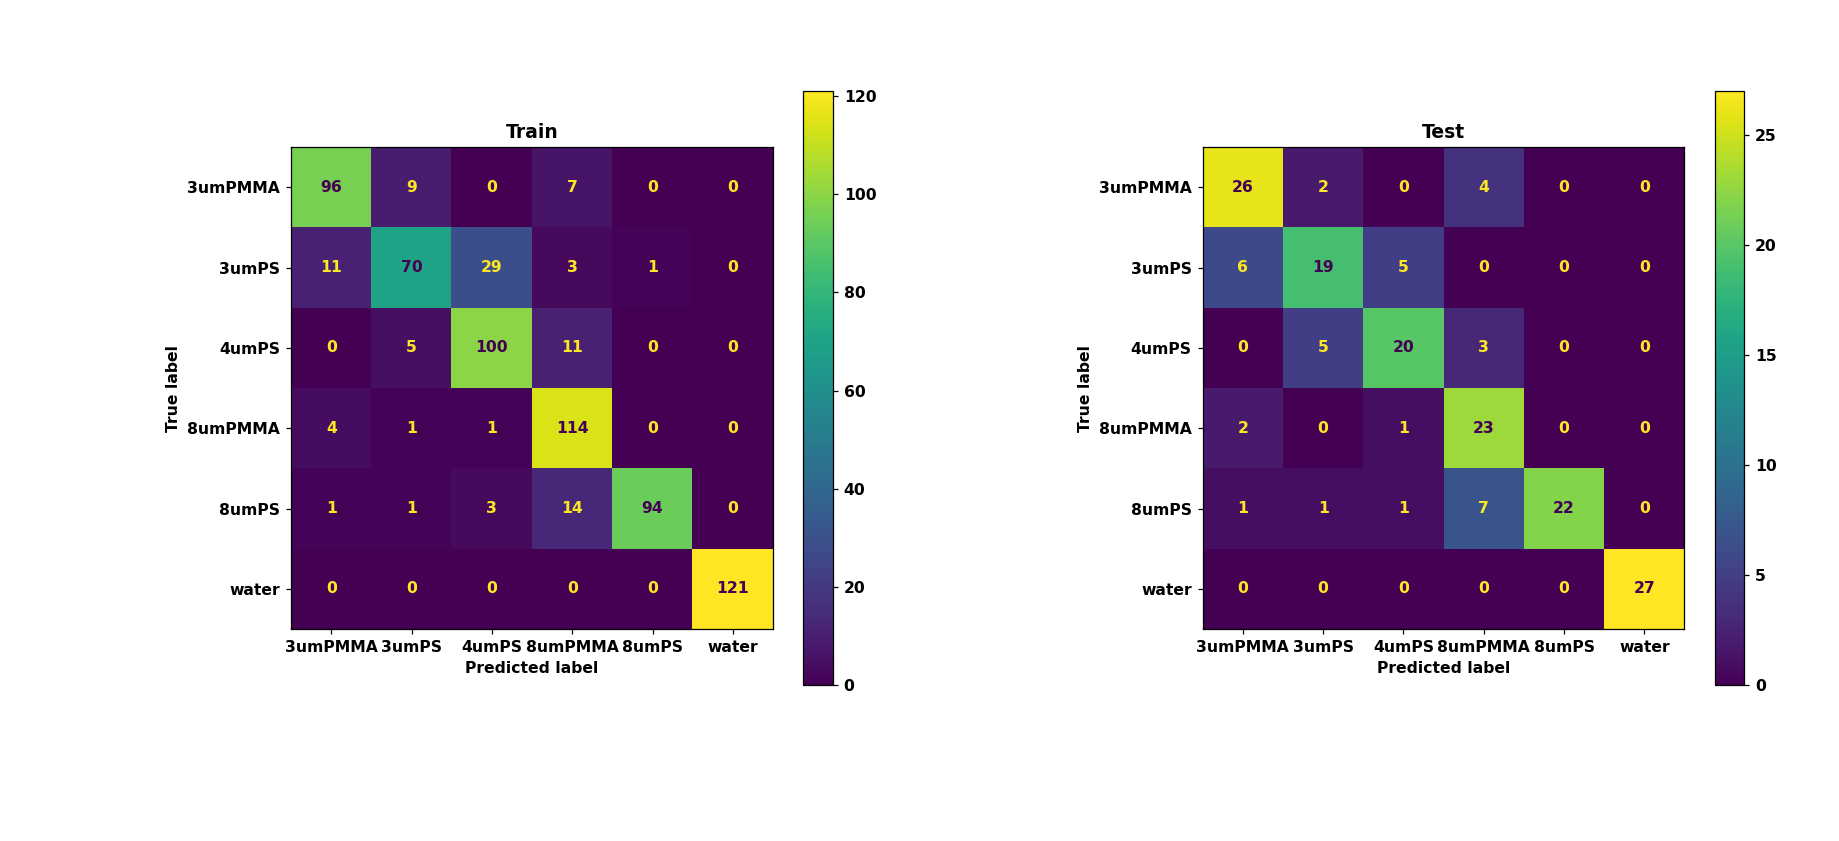

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=['3umPMMA' '3umPS' '4umPS' '8umPMMA' '8umPS' 'water'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=['3umPMMA' '3umPS' '4umPS' '8umPMMA' '8umPS' 'water'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [147]:
fig,ax = subplots(1,2,figsize=[8,3])


all_labels = np.unique(target)

cm = metrics.confusion_matrix(train_labels, predictions_train, all_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = all_labels)
disp.plot(ax=ax[0])
ax[0].set_title('Train')

cm = metrics.confusion_matrix(test_labels, predictions_test,all_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = all_labels)
disp.plot(ax=ax[1])
ax[1].set_title('Test')
tight_layout()

# Plots of X, Y, Sum as segments

<IPython.core.display.Javascript object>


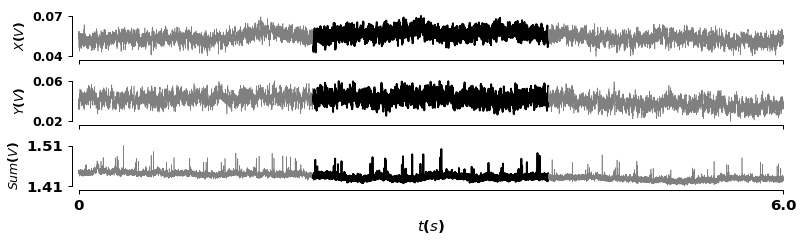

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator


In [10]:
%matplotlib notebook
subplots(figsize=[10,3])
subplot(311)
ax1=gca()
t0=0
dt=10e-5
ind=1
i=0
i1=0

times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(x_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, x_data[ind][i3],color='gray',ls='-',lw=0.5)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
    

ax1.set_ylabel(r"$X(V)$")
ax1.set_xticklabels([])
    
    
xrange=t0
factorx=0.01
    
ax1.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax1.set_xticks([0,t0])
ax1.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(x_data[ind][0:3])-np.min(x_data[ind][0:3])
factor=0.1
    
ax1.set_ylim(np.min(x_data[ind][0:3])-factor*yrange,np.max(x_data[ind][0:3])+factor*yrange)
ax1.spines['left'].set_bounds(np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3]))
ax1.set_yticks([np.min(x_data[ind][0:3]),np.max(x_data[ind][0:3])])
ax1.set_yticklabels([round(np.min(x_data[ind][0:3]),2),round(np.max(x_data[ind][0:3]),2)])

######################################################################################################
#######################################################################################################


subplot(312)
ax2=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(y_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, y_data[ind][i3],color='gray',ls='-',lw=0.5)


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
    

ax2.set_ylabel(r"$Y(V)$")
ax2.set_xticklabels([])
    
    
xrange=t0
factorx=0.01
    
ax2.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax2.set_xticks([0,t0])
ax2.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(y_data[ind][0:3])-np.min(y_data[ind][0:3])
factor=0.1
    
ax2.set_ylim(np.min(y_data[ind][0:3])-factor*yrange,np.max(y_data[ind][0:3])+factor*yrange)
ax2.spines['left'].set_bounds(np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3]))
ax2.set_yticks([np.min(y_data[ind][0:3]),np.max(y_data[ind][0:3])])
ax2.set_yticklabels([round(np.min(y_data[ind][0:3]),2),round(np.max(y_data[ind][0:3]),2)])


######################################################################################################
#######################################################################################################

subplot(313)
ax3=gca()
t0=0
dt=10e-5
i=0
i1=0
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i1],color='gray',lw=0.5)
i2=1
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i2],color='k',ls='-')
i3=2
times = t0+np.arange(0, len(sum_data[ind][i])*dt, dt)
t0=times[-1]
plot(times, sum_data[ind][i3],color='gray',ls='-',lw=0.5)


ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
    

ax3.set_ylabel(r"$Sum(V)$")
ax3.set_xticklabels([0,round(t0,2)],fontsize=12)
    
    
xrange=t0
factorx=0.01
    
ax3.set_xlim(0-factorx*xrange,t0+factorx*xrange)
ax3.set_xticks([0,t0])
ax3.spines['bottom'].set_bounds(0,t0)
    
yrange=np.max(sum_data[ind][0:3])-np.min(sum_data[ind][0:3])
factor=0.1
    
ax3.set_ylim(np.min(sum_data[ind][0:3])-factor*yrange,np.max(sum_data[ind][0:3])+factor*yrange)
ax3.spines['left'].set_bounds(np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3]))
ax3.set_yticks([np.min(sum_data[ind][0:3]),np.max(sum_data[ind][0:3])])
ax3.set_yticklabels([round(np.min(sum_data[ind][0:3]),2),round(np.max(sum_data[ind][0:3]),2)],fontsize=12)
ax3.set_xlabel(r"$t(s)$", fontsize=12)

tight_layout()
savefig('images/Segments',dpi=300)
 

# PCA Plot

In [11]:
from sklearn import *

ncomp=10


model = decomposition.PCA(n_components=ncomp)
#scaler = preprocessing.StandardScaler()
#scaler.fit(data_X)
#data_X = scaler.transform(data_X)
model.fit(data_X)
PCs1 = model.transform(data_X)

model2 = decomposition.PCA(n_components=ncomp)
model2.fit(data_Y)
PCs2 = model2.transform(data_Y)

model3 = decomposition.PCA(n_components=ncomp)
model3.fit(data_Sum)
PCs3 = model3.transform(data_Sum)


label0=unique_targets1[0]
label1=unique_targets1[1]
label2=unique_targets1[2]
label3=unique_targets1[3]
label4=unique_targets1[4]
label5=unique_targets1[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]



<IPython.core.display.Javascript object>


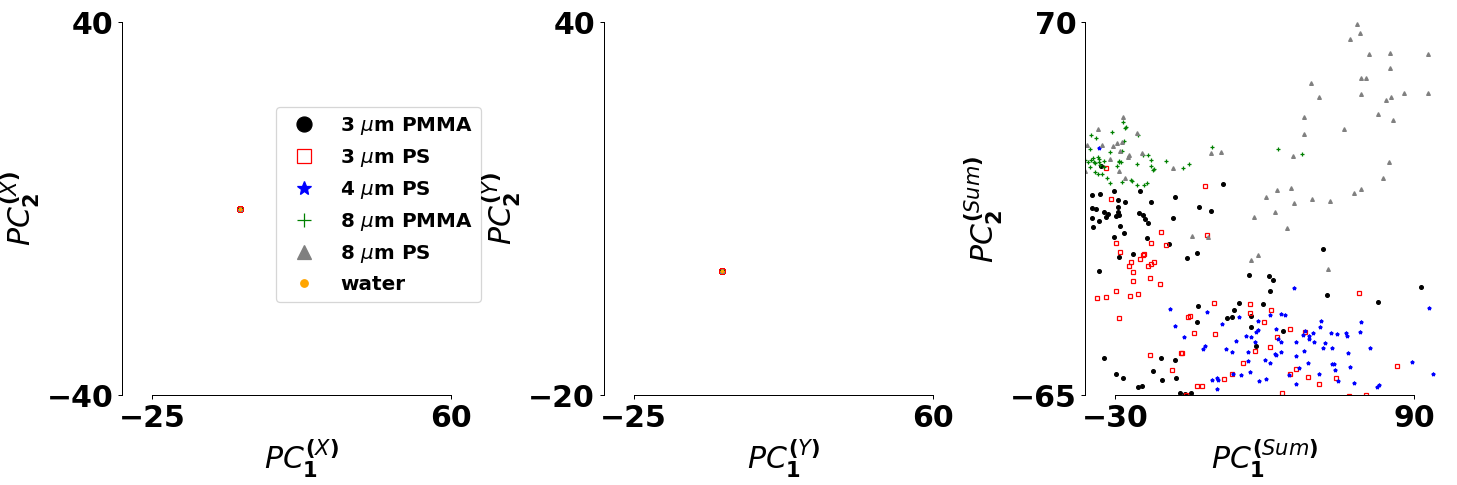

In [12]:
subplots(figsize=[18,6])
pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']
fs=24
fs1=24
fs2=16


subplot(131)
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-40,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(X)}_1$",fontsize=fs)
ylabel(r'$PC^{(X)}_2$',fontsize=fs)
ax.legend(fontsize=fs2,bbox_to_anchor=(0.4, 0.8),markerscale=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(132)
plot(PCs2[i0,pc1],PCs2[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs2[i1,pc1],PCs2[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs2[i2,pc1],PCs2[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs2[i3,pc1],PCs2[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs2[i4,pc1],PCs2[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs2[i5,pc1],PCs2[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-25,60])
ax.set_xticks([-25,60])
ax.set_ylim([-20,40])
ax.set_yticks([-20,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Y)}_1$",fontsize=fs)
ylabel(r'$PC^{(Y)}_2$',fontsize=fs)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])


subplot(133)
plot(PCs3[i0,pc1],PCs3[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(PCs3[i1,pc1],PCs3[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(PCs3[i2,pc1],PCs3[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(PCs3[i3,pc1],PCs3[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(PCs3[i4,pc1],PCs3[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(PCs3[i5,pc1],PCs3[i5,pc2],'.',markersize=3,color=c[5],label=label5)
ax=gca()
ax.set_xlim([-30,90])
ax.set_xticks([-30,90])
ax.set_ylim([-65,70])
ax.set_yticks([-65,70])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Sum)}_1$",fontsize=fs)
ylabel(r'$PC^{(Sum)}_2$',fontsize=fs)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax.get_xlim()[0],ax.get_xlim()[1]]
xrange=ax.get_xlim()[1]-ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0]-factorx*xrange,ax.get_xlim()[1]+factorx*xrange)
ax.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()
savefig('images/PCA',dpi=300)

In [34]:
import umap
n_neighbors=50
min_dist=0.6
n_components=3
metric='l2'

from sklearn.preprocessing import StandardScaler, minmax_scale
#scaler = StandardScaler()
#scaler.fit(data_X)
#data1 = scaler.transform(data_X)
fit = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
u = fit.fit_transform(np.column_stack([data_X,data_Y]))

In [35]:
subplots()
plot(u[i0,pc1],u[i0,pc2],'o',markersize=3,color=c[0],label=label0)
plot(u[i1,pc1],u[i1,pc2],'s',markersize=3,fillstyle='none', color=c[1],label=label1)
plot(u[i2,pc1],u[i2,pc2],'*',markersize=3,color=c[2],label=label2)
plot(u[i3,pc1],u[i3,pc2],'+',markersize=3,color=c[3],label=label3)
plot(u[i4,pc1],u[i4,pc2],'^',markersize=3,color=c[4],label=label4)
plot(u[i5,pc1],u[i5,pc2],'.',markersize=3,color=c[5],label=label5)
legend()

<IPython.core.display.Javascript object>

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc3 = 2

ax.scatter(u[i0,pc1],u[i0,pc2],u[i0,pc3],'o',color=c[0],label=label0)
ax.scatter(u[i1,pc1],u[i1,pc2],u[i1,pc3],'s', color=c[1],label=label1)
ax.scatter(u[i2,pc1],u[i2,pc2],u[i2,pc3],'*',color=c[2],label=label2)
ax.scatter(u[i3,pc1],u[i3,pc2],u[i3,pc3],'+',color=c[3],label=label3)
ax.scatter(u[i4,pc1],u[i4,pc2],u[i4,pc3],'^',color=c[4],label=label4)
ax.scatter(u[i5,pc1],u[i5,pc2],u[i5,pc3],'.',color=c[5],label=label5)
legend()

<IPython.core.display.Javascript object>

In [37]:
subplots()
plot(data1[0])
plot(data1[-2500])

<IPython.core.display.Javascript object>

NameError: name 'data1' is not defined

# Plot Principal Components

<IPython.core.display.Javascript object>


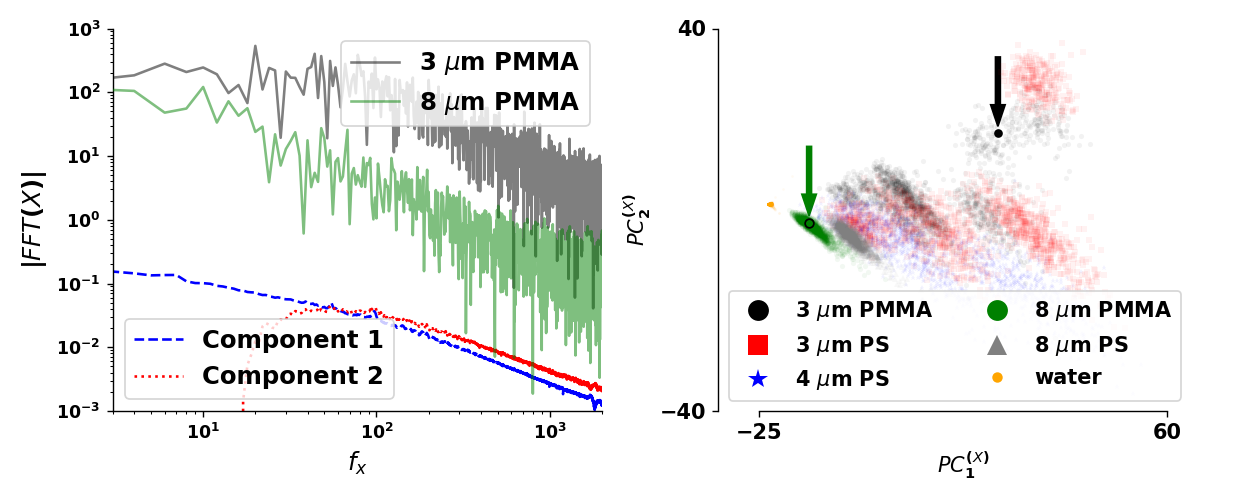

8 $\mu$m PMMA


In [9]:
subplots(figsize=[10,4])

subplot(121)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))
legend(loc=3,fontsize=14)

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_X[ind1])/2)
ax2.plot(freqs[:len2],data_X[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_X[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc=1,fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_x$", fontsize=14)
ax.set_ylabel("$|FFT(X)|$",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(122)
alpha=0.05
mw = 0.0
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
plot(PCs1[ind1,pc1],PCs1[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
plot(PCs1[ind2,pc1],PCs1[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12
ax3=gca()
ax3.set_xlim([-25,60])
ax3.set_xticks([-25,60])
ax3.set_ylim([-20,40])
ax3.set_yticks([-40,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(X)}_1$",fontsize=fs)
ylabel(r'$PC^{(X)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=2,markerscale=4)
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs1[ind1,pc1],PCs1[ind1,pc2]+16,0,-10,shape='full',width=1,color='k')
ax3.arrow(PCs1[ind2,pc1],PCs1[ind2,pc2]+16,0,-10,shape='full',width=1,color=c[3])
savefig('images\PCA_components',dpi=300)

<IPython.core.display.Javascript object>


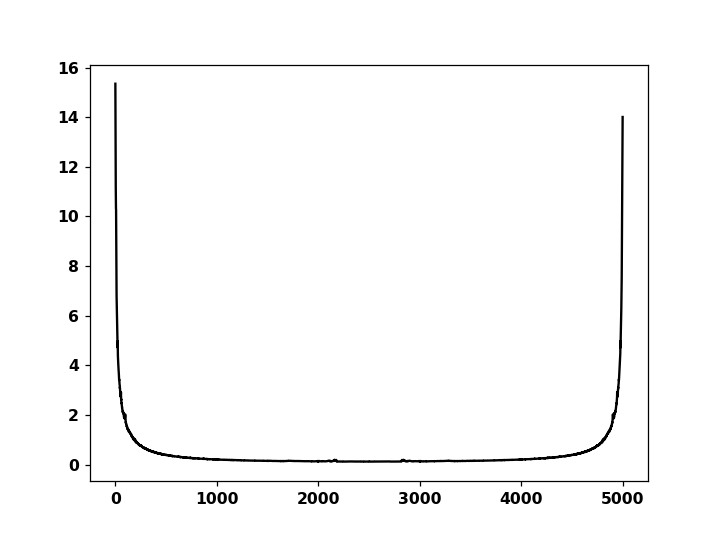

array([5.41297157, 4.75133215, 4.3644508 , ..., 4.01241103, 4.3644508 ,
       4.75133215])

In [10]:
subplots()
plot(model.mean_+model.inverse_transform(np.array([PCs1[ind1,pc1],PCs1[ind2,pc2],0,0,0,0,0,0,0,0])),color='k')
model.mean_

In [11]:
(model.mean_.shape + model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0]))).shape

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(4998,)

<IPython.core.display.Javascript object>


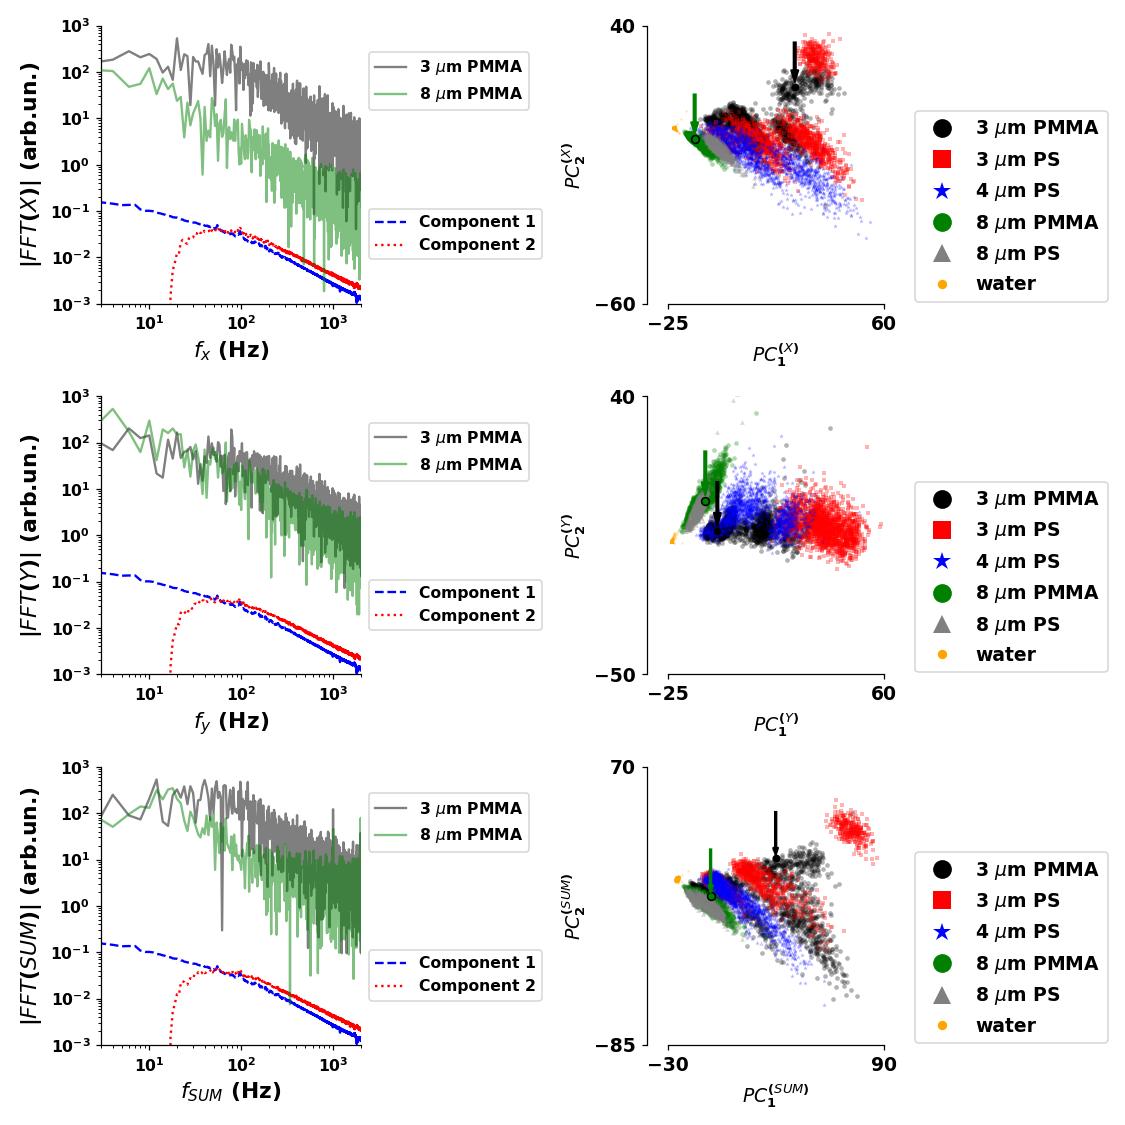

8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:98: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:192: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:283: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:284: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


In [17]:
subplots(figsize=[10,10])

subplot(321)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.25))
#legend(loc=3,fontsize=14)0

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_X[ind1])/2)
ax2.plot(freqs[:len2],data_X[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_X[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
#ax2.legend(loc=1,fontsize=14)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.8))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#ax.plot(model.mean_+ model.inverse_transform(np.array([PCs1[ind1,pc1],PCs1[ind1,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.mean_+ model.inverse_transform(np.array([PCs1[ind2,pc1],PCs1[ind2,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(model.mean_+PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_x$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(X)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(322)
alpha=0.3
mw = 0.0
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
plot(PCs1[ind1,pc1],PCs1[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
plot(PCs1[ind2,pc1],PCs1[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12
ax3=gca()
ax3.set_xlim([-25,60])
ax3.set_xticks([-25,60])
ax3.set_ylim([-60,40])
ax3.set_yticks([-60,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(X)}_1$",fontsize=fs)
ylabel(r'$PC^{(X)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=1,markerscale=4,loc='center left', bbox_to_anchor=(1, 0.35))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs1[ind1,pc1],PCs1[ind1,pc2]+16,0,-10,shape='full',width=1,color='k',edgecolor='k',zorder=10)
ax3.arrow(PCs1[ind2,pc1],PCs1[ind2,pc2]+16,0,-10,shape='full',width=1,color=c[3],edgecolor='k',zorder=10)


##########################################################################################

subplot(323)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25))

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_X[ind1])/2)
ax2.plot(freqs[:len2],data_Y[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_Y[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_y$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(Y)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(324)
alpha=0.3
mw = 0.0
plot(PCs2[i0,pc1],PCs2[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
plot(PCs2[i1,pc1],PCs2[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
plot(PCs2[i2,pc1],PCs2[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
plot(PCs2[i3,pc1],PCs2[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
plot(PCs2[i4,pc1],PCs2[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
plot(PCs2[i5,pc1],PCs2[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
plot(PCs2[ind1,pc1],PCs2[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
plot(PCs2[ind2,pc1],PCs2[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12
ax3=gca()
ax3.set_xlim([-25,60])
ax3.set_xticks([-25,60])
ax3.set_ylim([-50,40])
ax3.set_yticks([-50,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Y)}_1$",fontsize=fs)
ylabel(r'$PC^{(Y)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=1,markerscale=4,loc='center left', bbox_to_anchor=(1, 0.35))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs2[ind1,pc1],PCs2[ind1,pc2]+16,0,-10,shape='full',width=1,color='k',edgecolor='k',zorder=10)
ax3.arrow(PCs2[ind2,pc1],PCs2[ind2,pc2]+16,0,-10,shape='full',width=1,color=c[3],edgecolor='k',zorder=10)

########################################################################################################
subplot(325)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.25))

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_Sum[ind1])/2)
ax2.plot(freqs[:len2],data_Sum[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_Sum[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)


#ax.plot(PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_{SUM}$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(SUM)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(326)
alpha=0.3
mw = 0.0
ax3=gca()
ax3.plot(PCs3[i0,pc1],PCs3[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
ax3.plot(PCs3[i1,pc1],PCs3[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
ax3.plot(PCs3[i2,pc1],PCs3[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
ax3.plot(PCs3[i3,pc1],PCs3[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
ax3.plot(PCs3[i4,pc1],PCs3[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
ax3.plot(PCs3[i5,pc1],PCs3[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
ax3.plot(PCs3[ind1,pc1],PCs3[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
ax3.plot(PCs3[ind2,pc1],PCs3[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12

ax3.set_xlim([-30,90])
ax3.set_xticks([-30,90])
ax3.set_ylim([-85,70])
ax3.set_yticks([-85,70])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(SUM)}_1$",fontsize=fs)
ylabel(r'$PC^{(SUM)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=1,markerscale=4,loc='center left', bbox_to_anchor=(1, 0.35))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs3[ind1,pc1],PCs3[ind1,pc2]+16+10,0,-20,shape='full',width=1,color='k',edgecolor='w',zorder=10)
ax3.arrow(PCs3[ind2,pc1],PCs3[ind2,pc2]+16+10,0,-20,shape='full',width=1,color=c[3],edgecolor='w',zorder=10)

savefig('images\PCA_components',dpi=300)

<IPython.core.display.Javascript object>


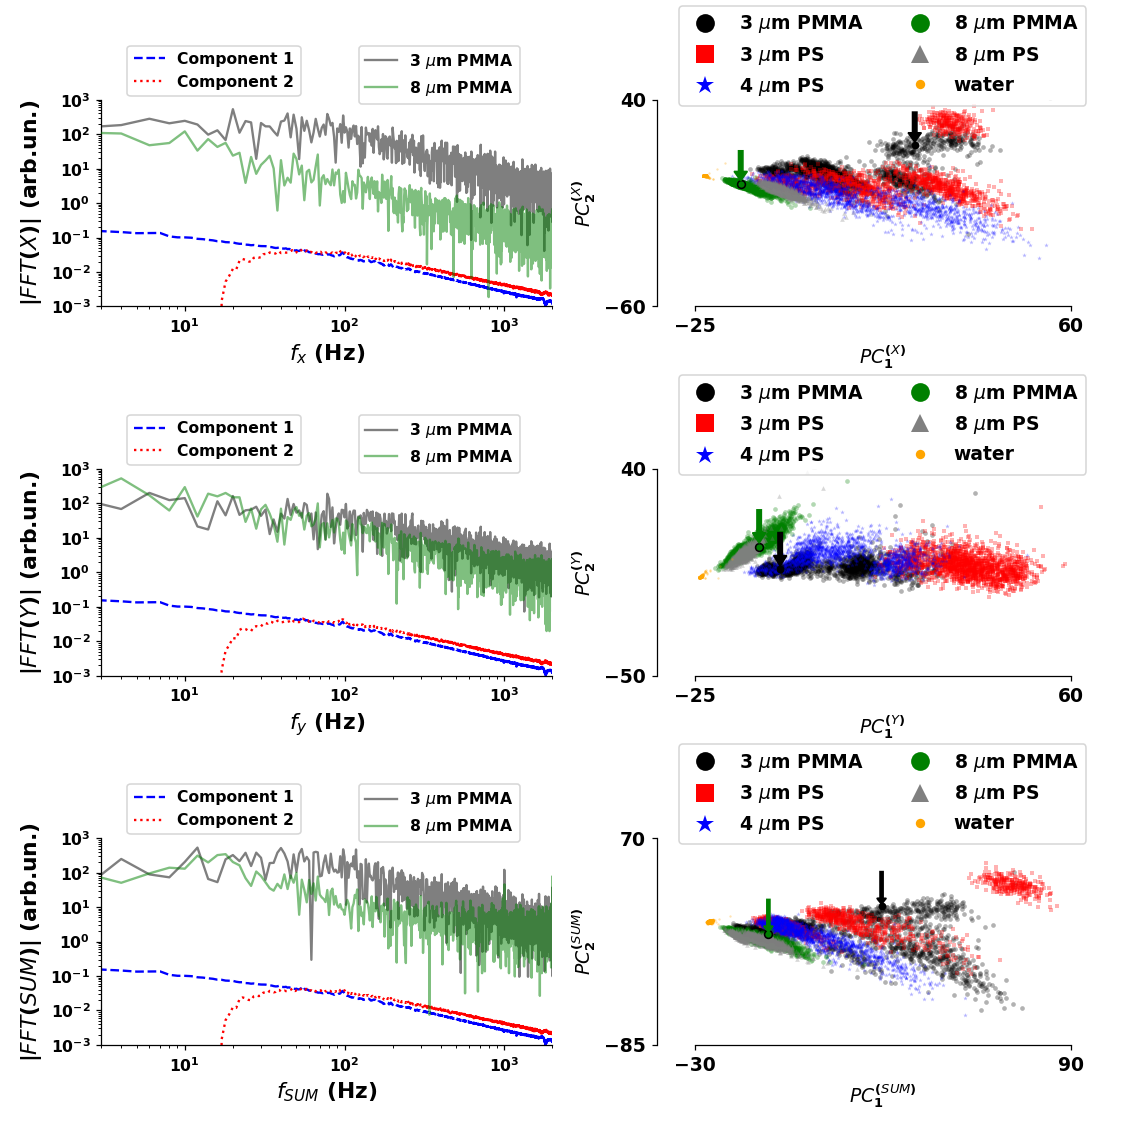

8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:98: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:192: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


8 $\mu$m PMMA


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:283: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:284: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


In [23]:
subplots(figsize=[10,10])

subplot(321)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))

ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3))
#legend(loc=3,fontsize=14)0

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_X[ind1])/2)
ax2.plot(freqs[:len2],data_X[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_X[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
#ax2.legend(loc=1,fontsize=14)
ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#ax.plot(model.mean_+ model.inverse_transform(np.array([PCs1[ind1,pc1],PCs1[ind1,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.mean_+ model.inverse_transform(np.array([PCs1[ind2,pc1],PCs1[ind2,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(model.mean_+PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_x$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(X)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(322)
alpha=0.3
mw = 0.0
plot(PCs1[i0,pc1],PCs1[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
plot(PCs1[i1,pc1],PCs1[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
plot(PCs1[i2,pc1],PCs1[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
plot(PCs1[i3,pc1],PCs1[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
plot(PCs1[i4,pc1],PCs1[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
plot(PCs1[i5,pc1],PCs1[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
plot(PCs1[ind1,pc1],PCs1[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
plot(PCs1[ind2,pc1],PCs1[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12
ax3=gca()
ax3.set_xlim([-25,60])
ax3.set_xticks([-25,60])
ax3.set_ylim([-60,40])
ax3.set_yticks([-60,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(X)}_1$",fontsize=fs)
ylabel(r'$PC^{(X)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=2,markerscale=4,loc='upper center', bbox_to_anchor=(0.5, 1.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs1[ind1,pc1],PCs1[ind1,pc2]+16,0,-10,shape='full',width=1,color='k',edgecolor='k',zorder=10)
ax3.arrow(PCs1[ind2,pc1],PCs1[ind2,pc2]+16,0,-10,shape='full',width=1,color=c[3],edgecolor='k',zorder=10)


##########################################################################################

subplot(323)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3))

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_X[ind1])/2)
ax2.plot(freqs[:len2],data_Y[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_Y[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[0])
#ax.plot(model.inverse_transform(np.array([PCs1[i0,pc1],PCs1[i0,pc2],0,0,0,0,0,0,0,0])),color=c[1])
#ax.plot(PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_y$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(Y)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(324)
alpha=0.3
mw = 0.0
plot(PCs2[i0,pc1],PCs2[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
plot(PCs2[i1,pc1],PCs2[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
plot(PCs2[i2,pc1],PCs2[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
plot(PCs2[i3,pc1],PCs2[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
plot(PCs2[i4,pc1],PCs2[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
plot(PCs2[i5,pc1],PCs2[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
plot(PCs2[ind1,pc1],PCs2[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
plot(PCs2[ind2,pc1],PCs2[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12
ax3=gca()
ax3.set_xlim([-25,60])
ax3.set_xticks([-25,60])
ax3.set_ylim([-50,40])
ax3.set_yticks([-50,40])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(Y)}_1$",fontsize=fs)
ylabel(r'$PC^{(Y)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=2,markerscale=4,loc='upper center', bbox_to_anchor=(0.5, 1.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs2[ind1,pc1],PCs2[ind1,pc2]+16,0,-10,shape='full',width=1,color='k',edgecolor='k',zorder=10)
ax3.arrow(PCs2[ind2,pc1],PCs2[ind2,pc2]+16,0,-10,shape='full',width=1,color=c[3],edgecolor='k',zorder=10)

########################################################################################################
subplot(325)
ax=gca()

ax.plot(model.components_[0],color='b',ls='--',label='Component 1')
ax.plot(model.components_[1],color='r',ls=':',label='Component 2')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim((3,2000))
ax.set_ylim((0.001,1000))
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.3))

ax2 = ax.twinx()


ind1 = 0
ind2 = 300*20
freqs = fft.fftfreq(len(x_data[0][0]),1e-4)[1:-1]
len2=int(len(data_Sum[ind1])/2)
ax2.plot(freqs[:len2],data_Sum[ind1][:len2],color=c[0], alpha = 0.5, label=unique_targets1[labels[ind1]])
ax2.plot(freqs[:len2],data_Sum[ind2][:len2],color=c[3], alpha = 0.5, label=unique_targets1[labels[ind2]])

ax2.set_yscale("log")
ax2.set_xscale("log")


ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(loc='upper center', bbox_to_anchor=(0.75, 1.3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)


#ax.plot(PCs1[ind1,pc1]*model.components_[0]+PCs1[ind1,pc2]*model.components_[1],color=c[0])
#ax.plot(np.abs(PCs1[ind2,pc1]*model.components_[0]+PCs1[ind2,pc2]*model.components_[1]),color=c[3])

ax.set_xlabel("$f_{SUM}$ (Hz)", fontsize=14)
ax.set_ylabel("$|FFT(SUM)|$ (arb.un.)",fontsize=14)

#ax.plot(freqs[100:len2],3*freqs[100:len2]**(-1.),':')
#ax.plot(freqs[50:len2-100],5*freqs[50:len2-100]**(-1),'--')

subplot(326)
alpha=0.3
mw = 0.0
ax3=gca()
ax3.plot(PCs3[i0,pc1],PCs3[i0,pc2],'o',markeredgewidth=mw,markersize=3,color=c[0],label=label0,alpha=alpha)
ax3.plot(PCs3[i1,pc1],PCs3[i1,pc2],'s',markeredgewidth=mw,markersize=3, color=c[1],label=label1,alpha=alpha)
ax3.plot(PCs3[i2,pc1],PCs3[i2,pc2],'*',markeredgewidth=mw,markersize=3,color=c[2],label=label2,alpha=alpha)
ax3.plot(PCs3[i3,pc1],PCs3[i3,pc2],'o',markeredgewidth=mw,markersize=3,color=c[3],label=label3,alpha=alpha)
ax3.plot(PCs3[i4,pc1],PCs3[i4,pc2],'^',markeredgewidth=mw,markersize=3,color=c[4],label=label4,alpha=alpha)
ax3.plot(PCs3[i5,pc1],PCs3[i5,pc2],'.',markeredgewidth=mw,markersize=3,color=c[5],label=label5,alpha=alpha)

ind1=0
ax3.plot(PCs3[ind1,pc1],PCs3[ind1,pc2],'.',markeredgewidth=mw,markersize=10,color=c[0])
print(label3)
mw=1
ax3.plot(PCs3[ind2,pc1],PCs3[ind2,pc2],'.',markeredgewidth=mw,markeredgecolor='k',markersize=10,color=c[3])

fs=12
fs1=12

ax3.set_xlim([-30,90])
ax3.set_xticks([-30,90])
ax3.set_ylim([-85,70])
ax3.set_yticks([-85,70])
xticks(fontsize=fs1)
yticks(fontsize=fs1)
xlabel(r"$PC^{(SUM)}_1$",fontsize=fs)
ylabel(r'$PC^{(SUM)}_2$',fontsize=fs)
leg = ax3.legend(fontsize=fs1,ncol=2,markerscale=4,loc='upper center', bbox_to_anchor=(0.5, 1.5))
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
factorx=0.1
prev_xlim = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
xrange=ax3.get_xlim()[1]-ax3.get_xlim()[0]
ax3.set_xlim(ax3.get_xlim()[0]-factorx*xrange,ax3.get_xlim()[1]+factorx*xrange)
ax3.spines['bottom'].set_bounds(prev_xlim[0],prev_xlim[1])
tight_layout()

ax3.arrow(PCs3[ind1,pc1],PCs3[ind1,pc2]+16+10,0,-20,shape='full',width=1,color='k',edgecolor='w',zorder=10)
ax3.arrow(PCs3[ind2,pc1],PCs3[ind2,pc2]+16+10,0,-20,shape='full',width=1,color=c[3],edgecolor='w',zorder=10)

savefig('images\PCA_components',dpi=300)

# Plot Explained Variance

<IPython.core.display.Javascript object>


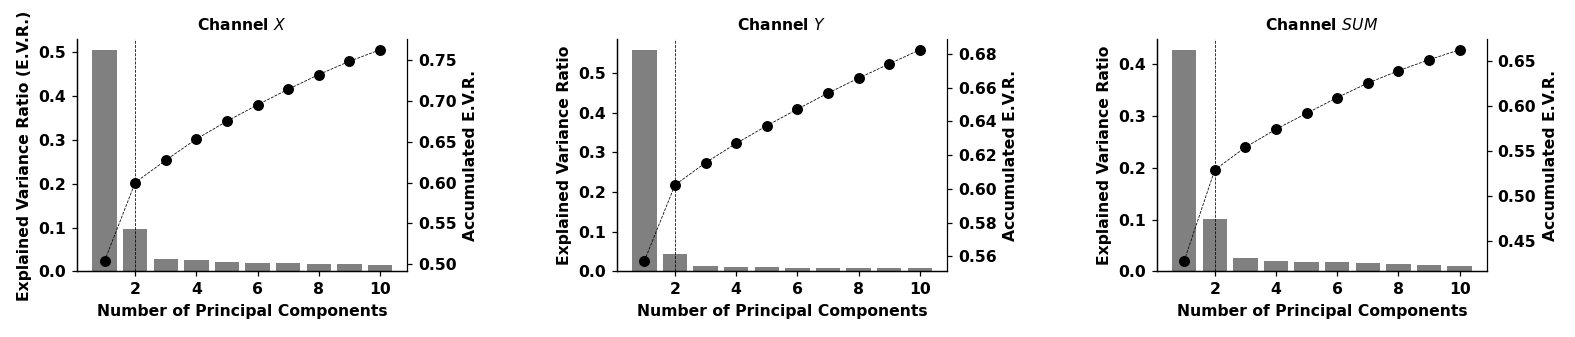

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: scipy.cumsum is deprecated and will be removed in SciPy 2.0.0, use numpy.cumsum instead
  
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: scipy.cumsum is deprecated and will be removed in SciPy 2.0.0, use numpy.cumsum instead
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: scipy.cumsum is deprecated and will be removed in SciPy 2.0.0, use numpy.cumsum instead


In [13]:
fs=10
subplots(figsize=[14,3])
subplot(131)
ax=gca()
ax.bar(range(1,ncomp+1),model.explained_variance_ratio_,color='grey')
ax.axvline(x=2,ls='--',lw=0.5,color='k')
ax.set_xlabel('Number of Principal Components',fontsize=fs)
ax.set_ylabel('Explained Variance Ratio (E.V.R.)',fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()

ax2.plot(range(1,ncomp+1),cumsum(model.explained_variance_ratio_),color='k',marker='o',ls='--',lw=0.5)
ax2.set_ylabel('Accumulated E.V.R.',fontsize=fs)
ax2.spines['top'].set_visible(False)
ax.set_title('Channel $X$',fontsize=fs)

################################################
subplot(132)
ax=gca()
ax.bar(range(1,ncomp+1),model2.explained_variance_ratio_,color='grey')
ax.axvline(x=2,ls='--',lw=0.5,color='k')
ax.set_xlabel('Number of Principal Components',fontsize=fs)
ax.set_ylabel('Explained Variance Ratio',fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()

ax2.plot(range(1,ncomp+1),cumsum(model2.explained_variance_ratio_),color='k',marker='o',ls='--',lw=0.5)
ax2.set_ylabel('Accumulated E.V.R.',fontsize=fs)
ax2.spines['top'].set_visible(False)
ax.set_title('Channel $Y$',fontsize=fs)
####################################################
subplot(133)
ax=gca()
ax.bar(range(1,ncomp+1),model3.explained_variance_ratio_,color='grey')
ax.axvline(x=2,ls='--',lw=0.5,color='k')
ax.set_xlabel('Number of Principal Components',fontsize=fs)
ax.set_ylabel('Explained Variance Ratio',fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()

ax2.plot(range(1,ncomp+1),cumsum(model3.explained_variance_ratio_),color='k',marker='o',ls='--',lw=0.5)
ax2.set_ylabel('Accumulated E.V.R.',fontsize=fs)
ax2.spines['top'].set_visible(False)
ax.set_title('Channel $SUM$',fontsize=fs)





tight_layout(w_pad=5)
savefig('images/Scree_plot_X',dpi=300)